In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots

In [2]:
format_plots()
#format_pizza_plots()

In [3]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [4]:
## update data
def filter_df(df):
    max=39
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [5]:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/dana_ontogeny_males_relabeled_usage_matrix_v00.parquet')
df_dana = pd.read_parquet(path)

path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)

In [6]:
# arrange data
data = df.astype(float, errors='ignore')
data= filter_df(data).groupby(['age','uuid']).mean()
data['data'] = 'min'
data.set_index('data', inplace=True, append=True)

data_dana = df_dana.astype(float, errors='ignore')
data_dana= filter_df(data_dana).groupby(['age','uuid']).mean()
data_dana['data'] = 'dana'
data_dana.set_index('data', inplace=True, append=True)

data_all = pd.concat([data,data_dana])
# choose 16 mice from all dataset
random_seed = 0
n=16
data_all = data_all.groupby('age').apply(lambda x: x.sample(n=n,replace=False,random_state=random_seed) if len(x)>n else x.sample(n=len(x),replace=False,random_state=random_seed)).reset_index(level=0, drop=True)
data_all = data_all[sorted(data_all.columns)]

In [7]:
data_labels = data_all.index.get_level_values('age').to_numpy()
data = data_all.to_numpy()

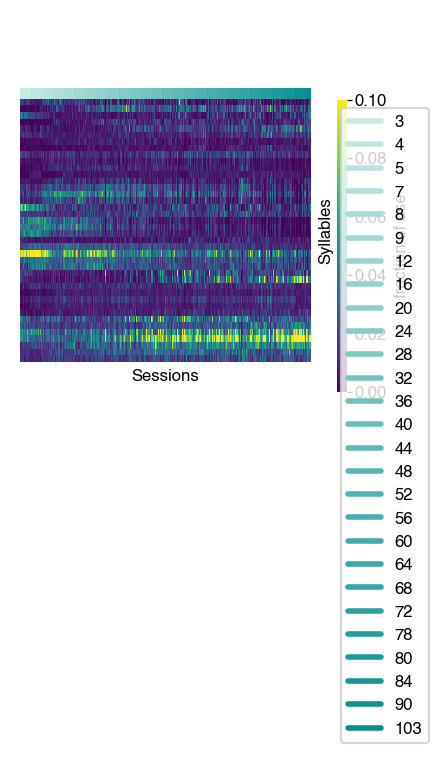

In [9]:
#colors for plotting
cmap2 = cmm
ages = np.unique(data_labels)
colors = np.int_(np.arange(0, 256, 256/len(ages)))
seqmatcolor='viridis'

# create age labels colors
lines=[]
counter = Counter(data_labels)
sorted(counter.items())
a=np.array([*counter.values()])

color_mat=[]
n=0
for i,c in enumerate(colors):
    for j in range(a[i]):
        color_mat.append(cmap2(c))

# plot
cg=sns.clustermap(
    data=data_all.T,
    cmap=seqmatcolor, 
    figsize=(2, 2),
    col_colors=color_mat,
    cbar_pos=(1.02, 0.025, 0.025, .73),
    col_cluster=False,
    row_cluster=True,
    yticklabels=False,
    xticklabels=False,
    #method='average',
    method = 'single',
    #metric='sqeuclidean',
    #metric='cosine',
    metric='jensenshannon',
    cbar_kws={'label': 'fraction of use'}, 
    vmax=0.10)
cg.ax_row_dendrogram.set_visible(False)
ax = cg.ax_heatmap
#ax.tick_params(left=False, bottom=False, right=False)
ax.set_xlabel('Sessions')
ax.set_ylabel('Syllables')

# legend
for i,c in enumerate(colors):
        lines.append(Line2D([0], [0], color=cmap2(c), lw=2))
plt.legend(handles=lines,labels=list(ages),bbox_to_anchor=(10, 1),loc='upper right',fontsize=6)
plt.show()

sraw = cg.dendrogram_row.reordered_ind

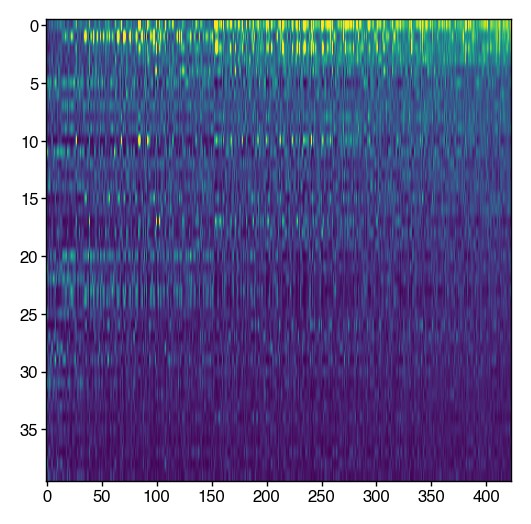

In [26]:
m=data_all.to_numpy()
# Calculate the pairwise correlation between rows
row_correlation = np.corrcoef(m)

# Get the order of rows after sorting by correlation
row_order = np.argsort(row_correlation.mean(axis=1))

# Resort the matrix based on the row order
sorted_m = m[row_order]

# Print the sorted matrix
plt.imshow(sorted_m.T, aspect='auto',cmap='viridis',vmax=0.1 )

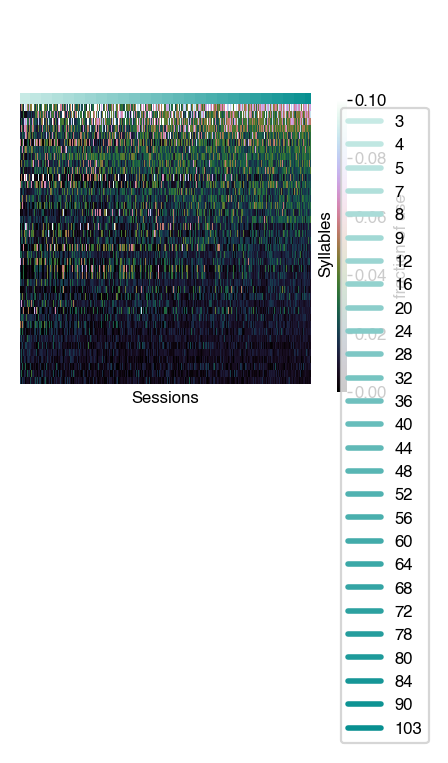

AttributeError: 'NoneType' object has no attribute 'reordered_ind'

In [30]:
#colors for plotting
cmap2 = cmm
ages = np.unique(data_labels)
colors = np.int_(np.arange(0, 256, 256/len(ages)))
seqmatcolor='cubehelix'

# create age labels colors
lines=[]
counter = Counter(data_labels)
sorted(counter.items())
a=np.array([*counter.values()])

color_mat=[]
n=0
for i,c in enumerate(colors):
    for j in range(a[i]):
        color_mat.append(cmap2(c))

# plot
cg=sns.clustermap(
    data=sorted_m.T,
    cmap=seqmatcolor, 
    figsize=(2, 2),
    col_colors=color_mat,
    cbar_pos=(1.02, 0.025, 0.025, .73),
    col_cluster=False,
    row_cluster=False,
    yticklabels=False,
    xticklabels=False,
    #method='average',
    method = 'single',
    #metric='sqeuclidean',
    #metric='cosine',
    metric='jensenshannon',
    cbar_kws={'label': 'fraction of use'}, 
    vmax=0.10)
cg.ax_row_dendrogram.set_visible(False)
ax = cg.ax_heatmap
#ax.tick_params(left=False, bottom=False, right=False)
ax.set_xlabel('Sessions')
ax.set_ylabel('Syllables')

# legend
for i,c in enumerate(colors):
        lines.append(Line2D([0], [0], color=cmap2(c), lw=2))
plt.legend(handles=lines,labels=list(ages),bbox_to_anchor=(10, 1),loc='upper right',fontsize=6)
plt.show()

sraw = cg.dendrogram_row.reordered_ind

In [28]:
from scipy.stats import spearmanr

# Assuming your matrix is already created and named 'm'

# Calculate the Spearman correlation between rows
row_correlation = np.zeros((m.shape[0], m.shape[0]))
for i in range(m.shape[0]):
    for j in range(m.shape[0]):
        row_correlation[i, j] = spearmanr(m[i], m[j]).correlation

# Get the order of rows after sorting by correlation
row_order = np.argsort(row_correlation.mean(axis=1))

# Resort the matrix based on the row order
sorted_m = m[row_order]

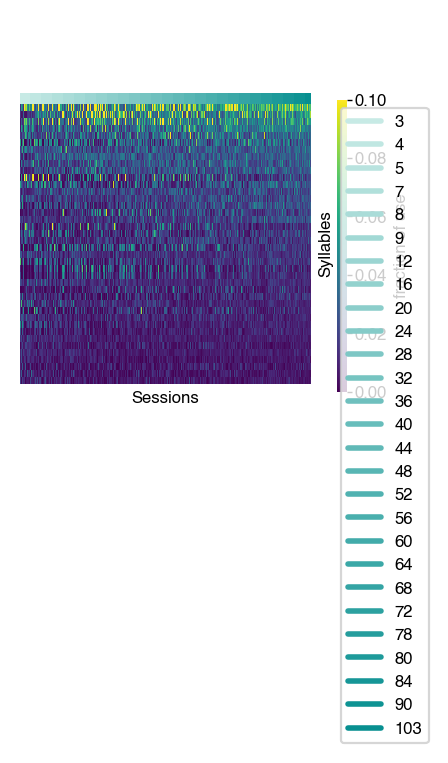

AttributeError: 'NoneType' object has no attribute 'reordered_ind'

In [29]:
#colors for plotting
cmap2 = cmm
ages = np.unique(data_labels)
colors = np.int_(np.arange(0, 256, 256/len(ages)))
seqmatcolor='viridis'

# create age labels colors
lines=[]
counter = Counter(data_labels)
sorted(counter.items())
a=np.array([*counter.values()])

color_mat=[]
n=0
for i,c in enumerate(colors):
    for j in range(a[i]):
        color_mat.append(cmap2(c))

# plot
cg=sns.clustermap(
    data=sorted_m.T,
    cmap=seqmatcolor, 
    figsize=(2, 2),
    col_colors=color_mat,
    cbar_pos=(1.02, 0.025, 0.025, .73),
    col_cluster=False,
    row_cluster=False,
    yticklabels=False,
    xticklabels=False,
    #method='average',
    method = 'single',
    #metric='sqeuclidean',
    #metric='cosine',
    metric='jensenshannon',
    cbar_kws={'label': 'fraction of use'}, 
    vmax=0.10)
cg.ax_row_dendrogram.set_visible(False)
ax = cg.ax_heatmap
#ax.tick_params(left=False, bottom=False, right=False)
ax.set_xlabel('Sessions')
ax.set_ylabel('Syllables')

# legend
for i,c in enumerate(colors):
        lines.append(Line2D([0], [0], color=cmap2(c), lw=2))
plt.legend(handles=lines,labels=list(ages),bbox_to_anchor=(10, 1),loc='upper right',fontsize=6)
plt.show()

sraw = cg.dendrogram_row.reordered_ind

In [ ]:
c = PlotConfig()
cg.savefig(c.dana_save_path / "fig2"/ 'male_syll_over_time_sorted.pdf', bbox_inches='tight')